# Leukemia patient classifier


## Introduction
This project focuses on classifying leukemia patients into two subgroups based on gene expression data: those with a chromosomal translocation (1) and those cytogenetically normal (-1). The dataset includes 79 patients and expression levels for 2,000 genes.

We apply supervised learning using Support Vector Machines (SVMs) to predict patient subgroups. Multiple kernel types (linear, polynomial, RBF) are tested with hyperparameter tuning via cross-validation. Additionally, we explore filtering the top 5% most variable genes to reduce noise and improve model performance.

In [244]:
from random import randint

# support libraries
import numpy as np
from matplotlib import pyplot as plt  # import subplots, cm
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
import pandas as pd

# lab-specific libraries
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay, roc_curve
from ISLP.svm import plot as plot_svm

We begin by splitting the data into training and test sets using scikit-learn, allocating 20% of the data for testing. Each model is then trained and evaluated on the training set using cross-validation to ensure robust performance estimation.

In [245]:
# Caricare il file
data = pd.read_csv("gene_expr.tsv", sep="\t")

# Division X and Y
X = data.drop(columns=["y", "sampleID"])  # tutte le colonne tranne l’etichetta
y = data["y"]

# split in train e validation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0, stratify=y)


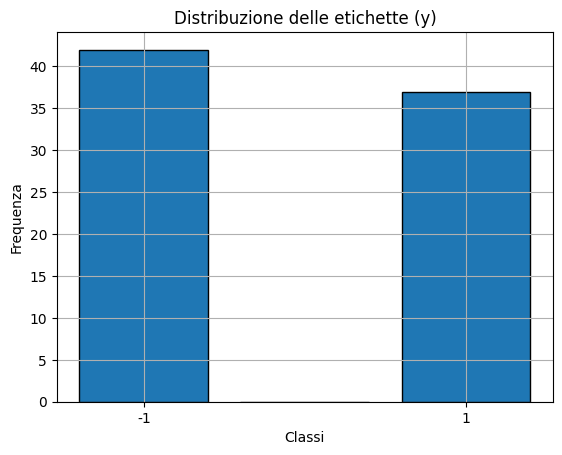

In [246]:
# Check the balanced
plt.hist(y, bins=[-1.5, -0.5, 0.5, 1.5], edgecolor='black', align='mid', rwidth=0.8)
# Etichette asse x personalizzate
plt.xticks([-1, 1], labels=['-1', '1'])
plt.xlabel('Classi')
plt.ylabel('Frequenza')
plt.title('Distribuzione delle etichette (y)')
plt.grid(True)
plt.show()

In [247]:
# creo una scoring dictionary per effettuare sempre le stessse valtazioni
scoring = {
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc'
}

### Linear fit
We first apply a Support Vector Machine with a linear kernel, which is often a suitable baseline for high-dimensional datasets like gene expression data. The regularization parameter C is optimized using cross-validation to balance model complexity and generalization performance.



In [248]:
# linear fit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
linear_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="linear", probability=True, random_state=0)),
])

## hyperparameter tuning
from sklearn.model_selection import GridSearchCV
parameters = {"svm__C":[0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_search_linear = GridSearchCV(
    estimator = linear_svm_clf,
    param_grid = parameters,
    scoring= "accuracy",
    n_jobs=-1,
    refit="accuracy",
    cv= skm.KFold(10, random_state=0, shuffle=True),
)
grid_search_linear.fit(X_train, y_train)


GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm',
                                        SVC(kernel='linear', probability=True,
                                            random_state=0))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             refit='accuracy', scoring='accuracy')

In [249]:
pd.DataFrame(grid_search_linear.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svm__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009211,0.000589,0.003941,0.000266,0.001,{'svm__C': 0.001},1.0,0.50,0.75,0.5,0.5,0.5,0.25,0.75,1.00,1.000000,0.675000,0.251247,1
1,0.009878,0.001123,0.004152,0.000305,0.010,{'svm__C': 0.01},1.0,0.25,0.75,0.5,1.0,0.5,0.25,0.75,0.75,0.666667,0.641667,0.252900,2
2,0.010506,0.000961,0.004627,0.001281,0.100,{'svm__C': 0.1},1.0,0.25,0.75,0.5,1.0,0.5,0.25,0.75,0.75,0.666667,0.641667,0.252900,2
3,0.012460,0.002264,0.005828,0.001608,1.000,{'svm__C': 1},1.0,0.25,0.75,0.5,1.0,0.5,0.25,0.75,0.75,0.666667,0.641667,0.252900,2
4,0.013250,0.003227,0.006487,0.002049,10.000,{'svm__C': 10},1.0,0.25,0.75,0.5,1.0,0.5,0.25,0.75,0.75,0.666667,0.641667,0.252900,2
5,0.013998,0.003164,0.004639,0.000831,100.000,{'svm__C': 100},1.0,0.25,0.75,0.5,1.0,0.5,0.25,0.75,0.75,0.666667,0.641667,0.252900,2
6,0.013049,0.001922,0.004355,0.000435,1000.000,{'svm__C': 1000},1.0,0.25,0.75,0.5,1.0,0.5,0.25,0.75,0.75,0.666667,0.641667,0.252900,2


In [250]:
grid_search_linear.best_score_
grid_search_linear.best_params_

{'svm__C': 0.001}

In [251]:
## Predictions
y_pred_linear = grid_search_linear.predict(X_test)
y_pred_proba_linear = grid_search_linear.predict_proba(X_test)[:, 1]

In [252]:
## Evaluation
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_linear)
cm

array([[16,  5],
       [ 8, 11]])

### Polynomail
We then extend the linear model by applying a polynomial kernel, which allows the SVM to capture non-linear relationships between gene expression features. Both the regularization parameter C and the polynomial degree are tuned via cross-validation.

In [253]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

polynoaml_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="poly", probability=True, random_state=0)),
])

## hyperparameter tuning
from sklearn.model_selection import GridSearchCV
parameters = {"svm__C":[0.001, 0.01, 0.1, 1, 10, 100, 1000],
              "svm__degree":[1,2,3,4,5,6]}

grid_search_poly = GridSearchCV(
    estimator = polynoaml_svm_clf,
    param_grid= parameters,
    scoring="accuracy",
    n_jobs=-1,
    refit="accuracy",
    cv=10,
)
grid_search_poly.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm',
                                        SVC(kernel='poly', probability=True,
                                            random_state=0))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'svm__degree': [1, 2, 3, 4, 5, 6]},
             refit='accuracy', scoring='accuracy')

In [254]:
## Predictions
y_pred_poly = grid_search_poly.predict(X_test)
y_pred_proba_poly = grid_search_poly.predict_proba(X_test)[:, 1]

In [255]:
## Evaluation
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_poly)
cm

array([[17,  4],
       [ 6, 13]])

### Gaussian kernel
Finally, we apply a Gaussian (RBF) kernel SVM, which is well suited for capturing complex and non-linear patterns in the data. We tune both the regularization parameter C and the kernel coefficient gamma using cross-validation.

In [256]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

gaussian_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", probability=True, random_state=0)),
])

## hyperparameter tuning
from sklearn.model_selection import GridSearchCV
parameters = {"svm__C":[0.001, 0.01, 0.1, 1, 10, 100, 1000],
              "svm__gamma": [0.0001, 0.001, 0.01, 0.1, 1, 10]}

grid_search_gaussian = GridSearchCV(
    estimator = gaussian_svm_clf,
    param_grid= parameters,
    scoring="accuracy",
    n_jobs=-1,
    refit="accuracy",
    cv=10,
)
grid_search_gaussian.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm',
                                        SVC(probability=True,
                                            random_state=0))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'svm__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             refit='accuracy', scoring='accuracy')

In [257]:
## Predictions
y_pred_rbf = grid_search_gaussian.predict(X_test)
y_pred_proba_rbf = grid_search_gaussian.predict_proba(X_test)[:, 1]

In [258]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_rbf)
cm

array([[18,  3],
       [ 6, 13]])

### Comparison of the models


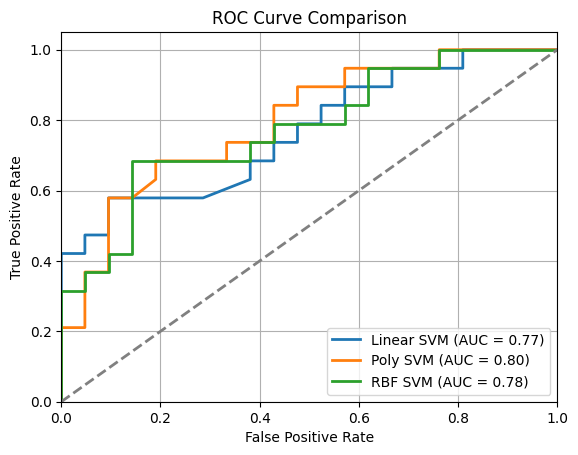

In [259]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcolo delle curve ROC e AUC
fpr_linear, tpr_linear, _ = roc_curve(y_test, y_pred_proba_linear)
roc_auc_linear = auc(fpr_linear, tpr_linear)

fpr_poly, tpr_poly, _ = roc_curve(y_test, y_pred_proba_poly)
roc_auc_poly = auc(fpr_poly, tpr_poly)

fpr_rbf, tpr_rbf, _ = roc_curve(y_test, y_pred_proba_rbf)
roc_auc_rbf = auc(fpr_rbf, tpr_rbf)

# Plot ROC curve sovrapposte
plt.figure()
plt.plot(fpr_linear, tpr_linear, lw=2, label=f'Linear SVM (AUC = {roc_auc_linear:.2f})')
plt.plot(fpr_poly, tpr_poly, lw=2, label=f'Poly SVM (AUC = {roc_auc_poly:.2f})')
plt.plot(fpr_rbf, tpr_rbf, lw=2, label=f'RBF SVM (AUC = {roc_auc_rbf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # random classifier line

# Layout
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid()
plt.show()


## Variance deletion
A popular approach in gene expression analysis is to keep only the most variable genes for downstream
analysis. Since most of the 2K genes have low expression or do not vary much across the experiments,
this step usually minimizes the contribution of noise. Select then only genes whose standard deviation
is among the top 5% and repeat the analyses performed in the previous task on the filtered data set.